[Reference](https://medium.com/@octavianzarzu/discovering-chess-openings-in-grandmasters-games-using-python-and-duckdb-e564d503665e)

In [1]:
!pip install chess.com chess duckdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1


In [2]:
import chessdotcom as cdc
import datetime
import chess.pgn
import io
import pandas as pd
import re
import duckdb

In [3]:
def get_top_players(num_players=100):
    leaderboards = cdc.get_leaderboards().json
    top_blitz_players = leaderboards['leaderboards']['live_blitz'][:num_players]
    return [player['username'] for player in top_blitz_players]

def get_games_for_player(username, months_ago=3):
    now = datetime.datetime.now()
    games = []

    for i in range(months_ago):
        month = (now - datetime.timedelta(days=(i * 30)))
        games_data = cdc.get_player_games_by_month(username, datetime_obj=month).json
        games.extend(games_data.get('games', []))
        
    return games



In [4]:
def uci_to_san(move_uci, board):
    move = chess.Move.from_uci(move_uci)
    san = board.san(move)
    board.push(move)
    return san

def process_moves(pgn_text):
    pgn_text = io.StringIO(pgn_text)
    pgn = chess.pgn.read_game(pgn_text)
    
    if pgn is None:
        return [], []

    white_moves = []
    black_moves = []
    turn = 1  # 1 for white, -1 for black

    board = pgn.board()

    for move in pgn.mainline_moves():
        san_move = board.san(move)
        if turn == 1:
            white_moves.append(san_move)
        else:
            black_moves.append(san_move)

        board.push(move)
        turn *= -1

    return white_moves, black_moves

In [5]:
num_players = 100
num_months = 3
top_players = get_top_players(num_players)
all_games = []

for player in top_players:
    print(player)
    games = get_games_for_player(player)
    for game in games:
        game_id = game['url'].split('/')[-1]

        pgn_text = game.get('pgn', '') 
        white_moves, black_moves = process_moves(pgn_text)

        all_games.append({
            'game_id': game_id,
            'white': game['white']['username'],
            'black': game['black']['username'],
            'white_moves': white_moves,
            'black_moves': black_moves,
        })
   
all_games_df = pd.DataFrame(all_games)

MagnusCarlsen
Hikaru
nihalsarin
GMWSO
Sibelephant
lachesisQ
spicycaterpillar
Bigfish1995
0gZPanda
Baku_Boulevard
FabianoCaruana
AnishGiri
Konavets
DanielNaroditsky
LyonBeast
NikoTheodorou
chesspanda123
LOVEVAE
wonderfultime
Polish_fighter3000
Duhless
Alexander_Zubov
Josh_2021
FairChess_on_YouTube
GOGIEFF
Azerichess
DenLaz
Grischuk
Msb2
penguingm1
RaunakSadhwani2005
viditchess
TRadjabov
Zhuu96
KuybokarovTemur
howitzer14
fireheart92
ShimanovAlex
mishanick
crescentmoon2411
Njal28
Ni-Hua
FEKKET-ESZTER
Salem-AR
OparinGrigoriy
GHANDEEVAM2003
GMharikrishna
Rickyzhou
Farrukh_Amonatov
amintabatabaei


In [6]:
all_games_df

,game_id,white,black,white_moves,black_moves
0,74274090045,MagnusCarlsen,Sibelephant,"[d4, c4, Nf3, Nc3, a4, e3, Bxc4, Nxd4, O-O, Qe...","[d5, c6, Nf6, dxc4, e6, c5, cxd4, Bc5, O-O, Nb..."
1,74277045761,Sibelephant,MagnusCarlsen,"[Nf3, c4, b3, Bb2, g3, Bg2, O-O, Nc3, d4, cxd5...","[Nf6, g6, Bg7, O-O, b6, Bb7, e6, Na6, d5, exd5..."
2,74279130461,MagnusCarlsen,Sibelephant,"[Nf3, g3, Bg2, O-O, c4, b3, d4, Bb2, Nc3, Bxc3...","[Nf6, g6, Bg7, O-O, c6, Ne4, d5, a5, Nxc3, Nd7..."
3,74282069875,Sibelephant,MagnusCarlsen,"[Nf3, g3, Bg2, d4, O-O, Nc3, a4, a5, Qd3, Rd1,...","[Nf6, g6, Bg7, O-O, d6, Nbd7, c6, Qc7, Re8, Rb..."
4,74285046009,Sibelephant,MagnusCarlsen,"[e4, g3, Bg2, Ne2, O-O, d3, Nbc3, f4, Be3, Qd2...","[c5, g6, Bg7, Nc6, d6, e5, Nge7, O-O, Be6, Nd4..."
...,...,...,...,...,...
22279,71358418221,Twitch_ElhamBlitz05,amintabatabaei,"[e4, Nc3, Bc4, d3, f4, Nf3, f5, Bg5, Qe2, dxc4...","[e5, Nc6, Nf6, Bc5, d6, O-O, Na5, c6, Nxc4, Qb..."
22280,71360694133,simplerXiao,amintabatabaei,"[e4, d4, exd5, Bd3, Ne2, c3, O-O, h3, Qb3, Be3...","[c6, d5, cxd5, Nc6, Bg4, e6, Bd6, Bh5, Qc7, Ng..."
22281,71361297421,amintabatabaei,UmutErdemGunduz,"[c4, g3, Bg2, Nc3, Nf3, d4, Nxd4, Bxh6, Qxd4, ...","[c5, g6, Bg7, Nc6, Nh6, cxd4, Nxd4, Bxh6, O-O,..."
22282,71361904367,JakubPulpan,amintabatabaei,"[Nf3, b3, Bb2, g3, Bg2, O-O, c4, d3, a3, Nbd2,...","[d5, Bf5, e6, h6, Nf6, Be7, O-O, a5, c6, Bh7, ..."


In [7]:
con = duckdb.connect()
con.execute('SELECT COUNT(DISTINCT game_id), COUNT(*) FROM all_games_df').df()

,count(DISTINCT game_id),count_star()
0,19114,22284


In [8]:
con.execute("""
SELECT *
FROM all_games_df
QUALIFY row_number() OVER (partition by game_id) = 1
"""
).df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,game_id,white,black,white_moves,black_moves
0,499697443,soccerdude37,0gZPanda,"[e3, Qh5, Bc4, Bb3, Qh4, Nf3, Ng5, Nf3, Ng5, Q...","[e5, Nc6, d5, Nf6, Be7, O-O, h6, Ne4, Bxg5, Nf..."
1,68984352341,tolkovoda,Rickyzhou,"[Nf3, g3, Bg2, O-O, c4, Qb3, d3, Be3, axb3, Bd...","[d5, c6, Nf6, Bf5, e6, Qb6, Nbd7, Qxb3, a6, h6..."
2,68987964579,Rickyzhou,abhijeetgupta,"[e4, Nf3, c3, h3, Bd3, exd5, O-O, Bb5, d4, Nxd...","[c5, d6, Nf6, Nc6, d5, Nxd5, e6, Bd6, cxd4, Bd..."
3,68997253279,Njal28,Msb2,"[e4, d4, Nc3, e5, f4, Nf3, Be3, Qd2, Be2, O-O,...","[e6, d5, Nf6, Nfd7, c5, Nc6, a6, b5, Be7, O-O,..."
4,69009747791,mishanick,Konavets,"[d4, c4, Nf3, Nc3, e3, Bd3, Bxc4, Bd3, O-O, Qc...","[Nf6, c6, d5, e6, Nbd7, dxc4, b5, Bb7, Bd6, O-..."
...,...,...,...,...,...
19109,75448179155,DanielNaroditsky,Njal28,"[d4, Nc3, Bf4, e4, Nxe4, dxc5, c3, Qa4+, Qxe4,...","[Nf6, d5, c5, Nxe4, dxe4, Qa5+, Qxc5, Nc6, g6,..."
19110,75449362105,DanielNaroditsky,Njal28,"[d4, Nc3, Bf4, e4, Nxe4, dxc5, c3, Qa4+, Qxe4,...","[Nf6, d5, c5, Nxe4, dxe4, Qa5+, Qxc5, Nc6, g6,..."
19111,75451156839,DanielNaroditsky,Njal28,"[e4, d4, Nc3, dxc5, bxc3, Bd3, Ne2, Be3, O-O, ...","[g6, Bg7, c5, Bxc3+, Nf6, Qa5, Qxc5, Qc7, d6, ..."
19112,75456630039,DanielNaroditsky,frederiksvane,"[h3, e4, Nf3, Bb5, O-O, d3, Nc3, Be3, Qd2, Bc4...","[h6, e5, Nc6, Nf6, d6, Bd7, g6, Bg7, a6, g5, N..."


In [9]:
ctas_popular_openings_query = """
CREATE TABLE popular_openings AS 
SELECT * FROM (
  VALUES
    ('Italian Game', ARRAY['e4', 'Nf3', 'Bc4'], ARRAY['e5', 'Nc6']),
    ('Sicilian Defense', ARRAY['e4'], ARRAY['c5']),
    ('French Defense', ARRAY['e4'], ARRAY['e6']),
    ('Caro-Kann Defense', ARRAY['e4'], ARRAY['c6']),
    ('Ruy Lopez (Spanish Opening)', ARRAY['e4', 'Nf3', 'Bb5'], ARRAY['e5', 'Nc6']),
    ('Slav Defense', ARRAY['d4', 'c4'], ARRAY['d5', 'c6']),
    ('Queens Gambit Declined', ARRAY['d4', 'c4'], ARRAY['d5', 'e6']),
    ('Kings Indian Defense', ARRAY['d4', 'c4', 'Nc3'], ARRAY['Nf6', 'g6', 'Bg7']),
    ('Nimzo-Indian Defense', ARRAY['d4', 'c4', 'Nc3'], ARRAY['Nf6', 'e6', 'Bb4']),
    ('Grunfeld Defense', ARRAY['d4', 'c4', 'Nc3'], ARRAY['Nf6', 'g6', 'd5']),
    ('English Opening', ARRAY['c4'], ARRAY[]),
    ('Reti Opening', ARRAY['Nf3'], ARRAY[]),
    ('Dutch Defense', ARRAY['d4'], ARRAY['f5']),
    ('Scandinavian Defense (Center Counter Defense)', ARRAY['e4'], ARRAY['d5']),
    ('Pirc Defense', ARRAY['e4', 'd4'], ARRAY['d6', 'Nf6']),
    ('Alekhines Defense', ARRAY['e4'], ARRAY['Nf6']),
    ('Modern Defense', ARRAY['e4', 'd4'], ARRAY['g6', 'Bg7']),
    ('Kings Gambit', ARRAY['e4', 'f4'], ARRAY['e5']),
    ('Vienna Game', ARRAY['e4', 'Nc3'], ARRAY['e5']),
    ('Philidor Defense', ARRAY['e4', 'Nf3'], ARRAY['e5', 'd6'])
) AS t (opening, white_moves, black_moves);"""

con.execute(ctas_popular_openings_query)

In [10]:
join_query = """
SELECT ifnull(po.opening, 'No common opening') as opening, COUNT(*) as count
FROM (
    SELECT * 
    FROM all_games_df 
    QUALIFY ROW_NUMBER() OVER (PARTITION BY game_id) = 1   
    ) agdf 
    LEFT JOIN popular_openings po ON agdf.white_moves[1:len(po.white_moves)] = po.white_moves AND agdf.black_moves[1:len(po.black_moves)] = po.black_moves
GROUP BY ALL
ORDER BY COUNT(*) DESC
"""

con.execute(join_query).df()

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

,opening,count
0,No common opening,8149
1,Reti Opening,2657
2,Sicilian Defense,2262
3,Caro-Kann Defense,935
4,English Opening,900
5,Ruy Lopez (Spanish Opening),599
6,French Defense,568
7,Scandinavian Defense (Center Counter Defense),455
8,Nimzo-Indian Defense,366
9,Queens Gambit Declined,355


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

<Axes: ylabel='opening'>

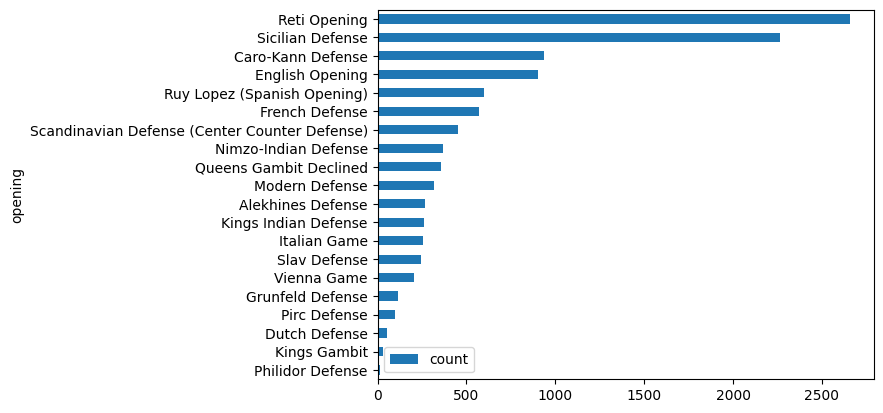

In [11]:
inner_join_query = """
SELECT ifnull(po.opening, 'No common opening') as opening, COUNT(*) as count
FROM (
    SELECT * 
    FROM all_games_df 
    QUALIFY ROW_NUMBER() OVER (PARTITION BY game_id) = 1   
    ) agdf 
    INNER JOIN popular_openings po ON agdf.white_moves[1:len(po.white_moves)] = po.white_moves AND agdf.black_moves[1:len(po.black_moves)] = po.black_moves
GROUP BY ALL
ORDER BY COUNT(*) ASC
"""

con.execute(inner_join_query).df().plot(x='opening', y='count', kind='barh')